# Load Data

In [4]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
plt.style.use('dark_background')
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : "/data/LiftPose3D_2602/fly_prism/data_oriented/training_data/", # change the path 
             'out_dir'        : './out',
             "train_subjects" : ["004"],
             'test_subjects'  : ["002"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'])

#project data to ventral view
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)
train_keypts = Z_coord_dict(train_keypts)
test_keypts = Z_coord_dict(test_keypts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [5]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'])

[main.py:252]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_2d.pth.tar.
[main.py:271]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:310]:DEBUG:===============

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  2.27291|: 100%|██████████| 24/24 [00:00<00:00, 32.97it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.30780 | Loss Train  1.72013|: 100%|██████████| 24/24 [00:00<00:00, 38.20it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.24366 | Loss Train  1.40158|: 100%|██████████| 24/24 [00:00<00:00, 39.66it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.20239 | Loss Train  1.17238|: 100%|██████████| 24/24 [00:00<00:00, 37.11it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.16840 | Loss Train  0.94787|: 100%|██████████| 24/24 [00:00<00:00, 37.13it/s]
Epoch 005 | LR  0.00100 | Loss Test  0.14956 | Loss Train  0.82007|: 100%|██████████| 24/24 [00:00<00:00, 46.35it/s]
Epoch 006 | LR  0.00100 | Loss Test  0.13971 | Loss Train  0.66756|: 100%|██████████| 24/24 [00:00<00:00, 38.71it/s]
Epoch 007 | LR  0.00100 | Loss Test  0.11366 | Loss Train  0.57246|: 100%|██████████| 24/24 [00:00<00:00, 45.20it/s]
Epoch 008 | LR  0.00100 | Loss Test  0.11625 | Loss Train  0.486

/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


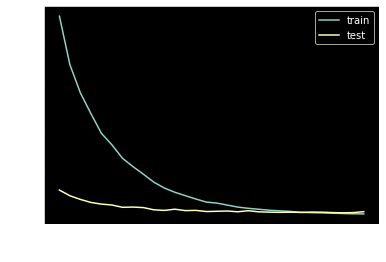

In [6]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [7]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:409]:INFO:starting testing in path: ./out
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.28M
[lift.py:66]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 28 | err: 2.2846298914873233)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_prism/out/test_results.pth.tar


# Visualize Predictions

In [8]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d, prism=True)
test_3d_gt *= 2.5/400
test_3d_pred *= 2.5/400

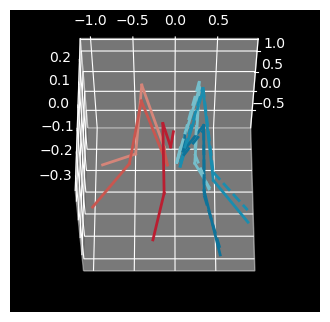

In [9]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
from liftpose.preprocess import add_roots
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-30, azim=0)

t = 100
plot_pose_3d(ax, tar=test_3d_gt[t],
            pred=test_3d_pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=True)

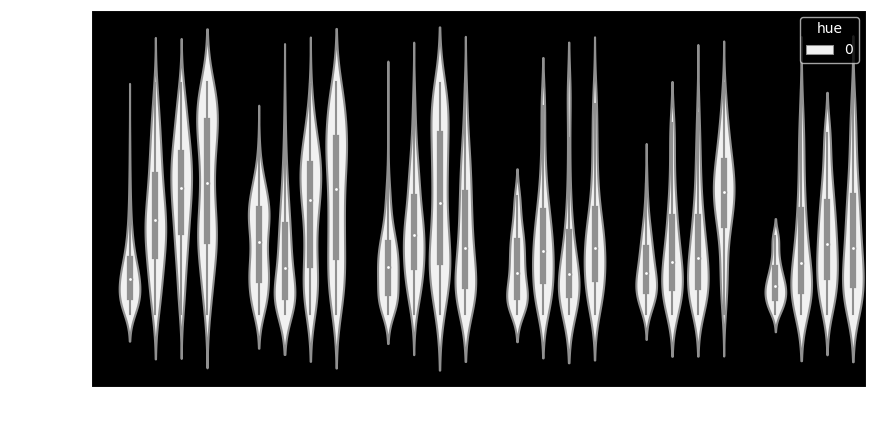

In [10]:
from liftpose.plot import violin_plot
# check violin plot 
# does it coincide with the mean values?
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
#order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = [str(i) for i in range(30)]
#order = names.copy()
#order.remove('Neck')
#order.remove('Tail')
ax = plt.gca()
violin_plot(ax, test_3d_gt=test_3d_gt, test_3d_pred=test_3d_pred, test_keypoints=good_keypts,
                joints_name=names, order=names)

In [174]:
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

#root_dir = '/data/fly_prism'
scale = 2.5/400
all_err = torch.load('./test_results.pth.tar')['all_err']
all_err*=scale
ttl_err = pd.DataFrame(all_err.reshape(-1,4)).dropna()
ttl_err.columns.names = ['frame']
ttl_err = ttl_err.rename(columns={0:'coxa-femur',1:'femur-tibia',2:'tibia-tarsus',3:'tarsus-tip'})
ttl_err['total'] = ttl_err.mean(1)

In [175]:
all_err.shape

(6990, 24)

(0.0, 0.04)

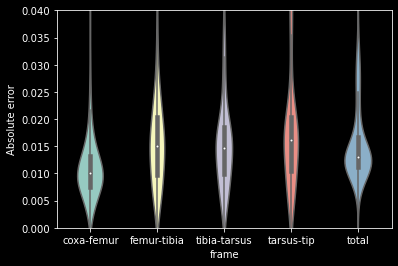

In [69]:
plt.style.use('dark_background')
ttl_err1 = ttl_err.unstack().reset_index()
ttl_err1 = ttl_err1.rename(columns={0:'Absolute error'})
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1.loc[ttl_err1['Absolute error'] < q['Absolute error']]
sns.violinplot(x="frame", y='Absolute error', data=ttl_err1,bw=0.4, width=0.4)
plt.ylim([0,0.04])
#plt.savefig('/results/Figure_2E.png')

(1507, 24)


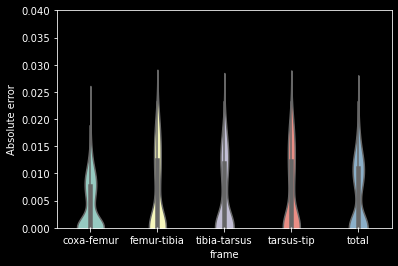

In [70]:
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

#root_dir = '/data/fly_prism'
scale = 2.5/400
all_err = torch.load('./out/test_results.pth.tar')['all_err']
all_err*=scale
ttl_err = pd.DataFrame(all_err.reshape(-1,4)).dropna()
ttl_err.columns.names = ['frame']
ttl_err = ttl_err.rename(columns={0:'coxa-femur',1:'femur-tibia',2:'tibia-tarsus',3:'tarsus-tip'})
ttl_err['total'] = ttl_err.mean(1)

plt.style.use('dark_background')
ttl_err1 = ttl_err.unstack().reset_index()
ttl_err1 = ttl_err1.rename(columns={0:'Absolute error'})
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1.loc[ttl_err1['Absolute error'] < q['Absolute error']]
sns.violinplot(x="frame", y='Absolute error', data=ttl_err1,bw=0.4, width=0.4)
plt.ylim([0,0.04])
#plt.savefig('/results/Figure_2E.png')
print(all_err.shape)

In [167]:
# reproduce from code-ocean
import stats
def abs_error(abs_error,n_pts):
    error = np.zeros((abs_error.shape[0], n_pts))
    for k in range(n_pts):
        error[:, k] = np.mean(abs_error[:, 3*k:3*(k + 1)], axis=1)
        
    return error

import stats
lift = torch.load('test_results.pth.tar')
stat = torch.load('stat_3d.pth.tar')

#lifting error
dimensions = stat['targets_1d']
lift_tar = stats.unNormalize(lift['target'], stat['mean'][dimensions], stat['std'][dimensions])
lift_out = stats.unNormalize(lift['output'], stat['mean'][dimensions], stat['std'][dimensions])

#absdiff = np.abs(lift_tar - lift_out)
#n_pts = len(dimensions)//3
#lift_error = abs_error(absdiff,n_pts)

#lift_tar = lift_tar.reshape(lift_tar.shape[0], -1, 3)
#lift_out = lift_out.reshape(lift_out.shape[0], -1, 3)

lift_tar = repeat(lift_tar, 'b j -> b j c', c=3) *2.5/400
lift_out = repeat(lift_out, 'b j -> b j c', c=3) *2.5/400
lift_tar[:, :, [0,1]] = 0
lift_out[:, :, [0,1]] = 0

In [168]:
lift['target'].shape

(6990, 24)

(0.0, 0.04)

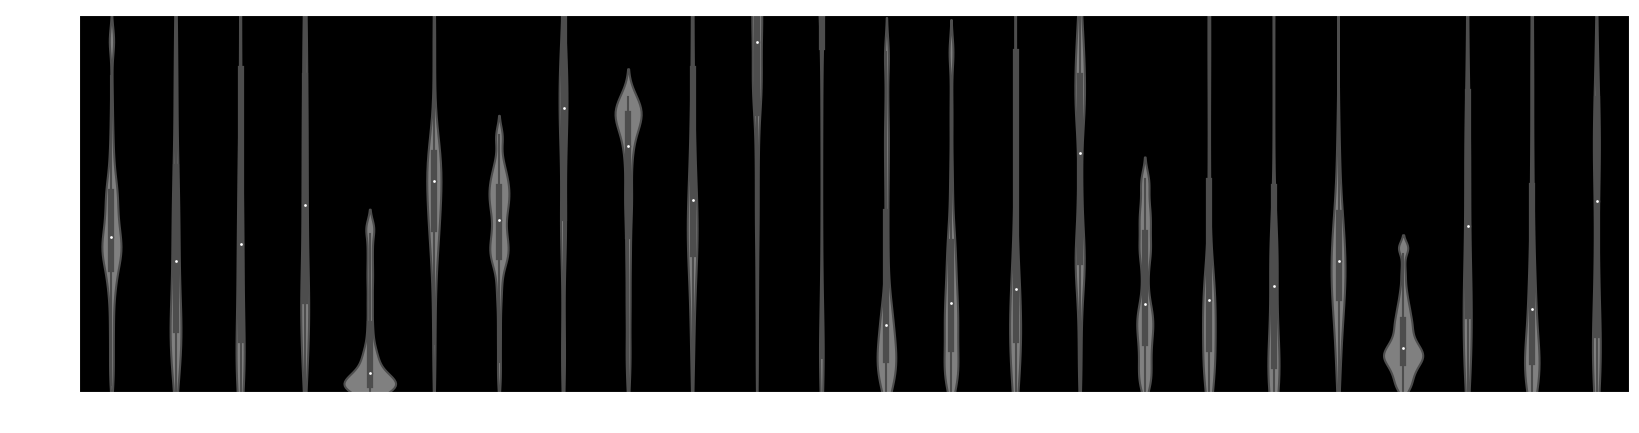

In [178]:
from einops import rearrange, reduce, repeat
from liftpose.plot import violin_plot
plt.figure(figsize=(20,5), dpi=100)
names = [str(i) for i in range(24)]
ax = plt.gca()
violin_plot(ax, test_3d_gt=lift_tar, test_3d_pred=lift_out,
                test_keypoints=np.ones_like(lift_tar),
                joints_name=names, order=names)
plt.ylim([0, 0.04])